In [11]:
from glob import glob
from concurrent.futures import ProcessPoolExecutor

import numpy as np
import nibabel as nib
from matplotlib import pyplot as plt
import pandas as pd

from nilearn.image import resample_img, resample_to_img

In [2]:
plt.rcParams["figure.dpi"] = 150
plt.style.use("ggplot")

In [3]:
def corr_ratio(x: np.ndarray, y: np.ndarray, bins: int = 256) -> float:
    """
    Flirt correlation ratio cost function between `x` and `y`. Measures the variance
    in `y` over each iso-set of `x`.

    See [Jenkinson, NeuroImage 2002](https://doi.org/10.1006/nimg.2002.1132),
    Table 1 for the definition.
    """
    assert x.shape == y.shape, "x and y expected to have same shape"

    _, edges = np.histogram(x, bins=bins)
    count, cost = 0, 0.0
    for ii in range(bins):
        left, right = edges[ii: ii + 2]
        mask = (x >= left) & (x < right)
        iso_count = mask.sum()
        if iso_count > 0:
            y_iso_var = np.var(y[mask])
            cost = cost + iso_count * y_iso_var
            count = count + iso_count
    cost = cost / (np.var(y) * count)
    return cost

In [4]:
def corr(x: np.ndarray, y: np.ndarray) -> float:
    """
    Correlation between two arrays.
    """
    assert x.shape == y.shape, "x and y expected to have same shape"
    x = x.flatten()
    y = y.flatten()
    c = np.sum(x * y) / (np.linalg.norm(x) * np.linalg.norm(y))
    return c

In [5]:
def dice(x: np.ndarray, y: np.ndarray) -> float:
    """
    Correlation between two masks
    """
    assert x.shape == y.shape, "x and y expected to have same shape"
    x = x > 0
    y = y > 0
    d = 2 * np.sum(x * y) / (x.sum() + y.sum())
    return d

In [6]:
def match_pattern(pattern: str) -> str:
    matches = glob(pattern)
    return None if len(matches) == 0 else matches[0]

In [7]:
def load_images(sesdir: str):
    images = {}
    images["t1w"] = match_pattern(f"{sesdir}/anat/*_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz")
    images["t1w_brain_mask"] = match_pattern(f"{sesdir}/anat/*_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz")
    images["boldref"] = match_pattern(f"{sesdir}/func/*_space-MNI152NLin2009cAsym_boldref.nii.gz")
    images["boldref_brain_mask"] = match_pattern(f"{sesdir}/func/*_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz")

    for k, path in images.items():
        images[k] = nib.load(path)
    
    for k in ["t1w", "t1w_brain_mask"]:
        interpolation = "nearest" if "mask" in k else "continuous"
        images[k] = resample_img(
            images[k], target_affine=(2.0 * np.eye(3)), interpolation=interpolation
        )

    for k in ["boldref", "boldref_brain_mask"]:
        interpolation = "nearest" if "mask" in k else "continuous"
        images[k] = resample_to_img(images[k], images["t1w"], interpolation=interpolation)
    
    for k, img in images.items():
        images[k] = img.get_fdata()
    
    for k in ["t1w", "boldref"]:
        images[k] = images[k] * (images[f"{k}_brain_mask"] > 0)
    return images

In [8]:
subs = pd.read_csv("../etc/select_subs.csv")
subs.head()

,dataset,subject,session,sub_ses,fmap,task
0,NKI,A00031893,BAS1,sub-A00031893_ses-BAS1,none,task-rest_acq-1400
1,NKI,A00035377,BAS1,sub-A00035377_ses-BAS1,none,task-rest_acq-1400
2,NKI,A00035827,BAS2,sub-A00035827_ses-BAS2,none,task-rest_acq-1400
3,NKI,A00040815,BAS1,sub-A00040815_ses-BAS1,none,task-rest_acq-1400
4,NKI,A00052182,FLU2,sub-A00052182_ses-FLU2,none,task-rest_acq-1400


In [9]:
def evaluate(sub: str, ses: str, fmap: str):
    metrics = {"subject": sub, "session": ses, "fmap": fmap}
    dc_images = load_images(f"../output/fmriprep_dc/sub-{sub}/ses-{ses}")
    nodc_images = load_images(f"../output/fmriprep_nodc/sub-{sub}/ses-{ses}")
    
    metrics["dc_to_nodc_boldref_corr"] = corr(
        dc_images["boldref"],
        nodc_images["boldref"],
    )
    metrics["dc_to_nodc_bold_mask_dice"] = dice(
        dc_images["boldref_brain_mask"],
        nodc_images["boldref_brain_mask"],
    )
    metrics["dc_boldref_t1w_corr_ratio"] = corr_ratio(
        dc_images["t1w"],
        dc_images["boldref"],
    )
    metrics["nodc_boldref_t1w_corr_ratio"] = corr_ratio(
        nodc_images["t1w"],
        nodc_images["boldref"],
    )
    return metrics

In [13]:
futures, results = [], []

with ProcessPoolExecutor(max_workers=8) as pool:
    for sub, ses, fmap in zip(subs["subject"], subs["session"], subs["fmap"]):
        futures.append(pool.submit(evaluate, sub, ses, fmap))

    for future, sub, ses in zip(futures, subs["subject"], subs["session"]):
        print(sub, ses)
        results.append(future.result())    

A00031893 BAS1
A00035377 BAS1
A00035827 BAS2
A00040815 BAS1
A00052182 FLU2
A00065992 TRT
A00066860 BAS1
A00066865 BAS1
A00074709 BAS1
A00081552 FLU1
NDARAA306NT2 HBNsiteRU
NDARBE091BGD HBNsiteRU
NDARDZ266KET HBNsiteRU
NDARFG943GVZ HBNsiteCBIC
NDARFM229HHA HBNsiteCBIC
NDARHW933UVJ HBNsiteCBIC
NDARJL656RDA HBNsiteCBIC
NDARMB857WG7 HBNsiteCBIC
NDARMG263JRX HBNsiteRU
NDARMV718DYL HBNsiteRU
1161831083 PNC1
1169616649 PNC1
1695950181 PNC1
2824066679 PNC1
3092187032 PNC1
3123810007 PNC1
3176046588 PNC1
3185151244 PNC1
3692156343 PNC1
56162563 PNC1


In [14]:
results = pd.DataFrame.from_records(results)
results["dc_to_nodc_corr_ratio_delta"] = (
    results["dc_boldref_t1w_corr_ratio"] - results["nodc_boldref_t1w_corr_ratio"]
)
results

,subject,session,fmap,dc_to_nodc_boldref_corr,dc_to_nodc_bold_mask_dice,dc_boldref_t1w_corr_ratio,nodc_boldref_t1w_corr_ratio,dc_to_nodc_corr_ratio_delta
0,A00031893,BAS1,none,0.999315,0.997329,0.125241,0.125382,-0.000141
1,A00035377,BAS1,none,0.999356,0.997653,0.136376,0.136941,-0.000565
2,A00035827,BAS2,none,0.999205,0.996475,0.163904,0.164760,-0.000856
3,A00040815,BAS1,none,0.989327,0.966890,0.140772,0.133697,0.007075
4,A00052182,FLU2,none,0.997220,0.992641,0.192647,0.194530,-0.001883
5,A00065992,TRT,none,0.999102,0.997339,0.130102,0.129299,0.000803
6,A00066860,BAS1,none,0.947922,0.917347,0.104494,0.186693,-0.082199
7,A00066865,BAS1,none,0.992440,0.976430,0.142239,0.131416,0.010823
8,A00074709,BAS1,none,0.999119,0.996792,0.129908,0.130846,-0.000938
9,A00081552,FLU1,none,0.993930,0.976645,0.159311,0.166256,-0.006945


In [15]:
def plot_scatter(col: str, title: str = None):
    fmaps = ["none", "epi", "phasediff"]
    colors = ["r", "g", "b"]
    
    delta = 0.1
    for ii, fmap in enumerate(fmaps):
        x = results.loc[results["fmap"] == fmap, col].values
        plt.boxplot(x, positions=[(ii + 1 - delta)])
        plt.scatter(np.random.rand(len(x)) * 0.05 + delta + ii + 1, x, color=colors[ii], alpha=0.5)
    plt.xticks([1, 2, 3], fmaps, rotation=45)
    if title is not None:
        plt.title(title)

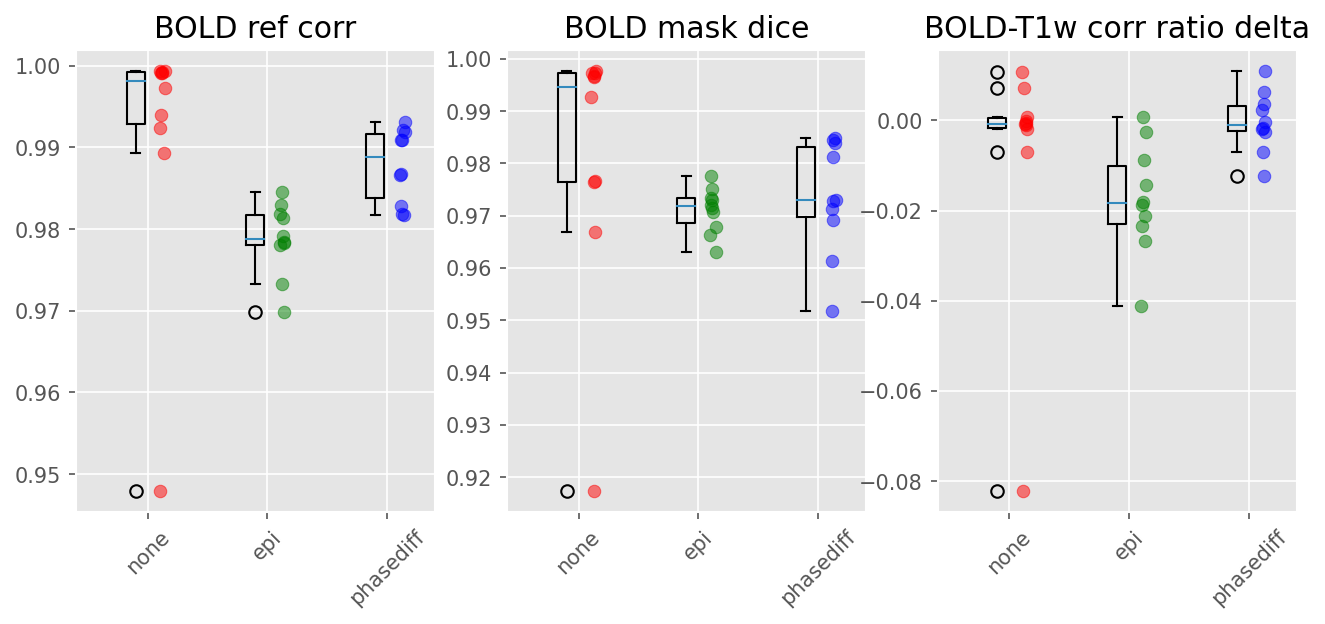

In [16]:
cols = [
    ("dc_to_nodc_boldref_corr", "BOLD ref corr"),
    ("dc_to_nodc_bold_mask_dice", "BOLD mask dice"),
    ("dc_to_nodc_corr_ratio_delta", "BOLD-T1w corr ratio delta"),
]

plotw, ploth = 3.5, 4.0
nr, nc = 1, len(cols)
f, axs = plt.subplots(nr, nc, figsize=(nc * plotw, nr * ploth))

for ii in range(nc):
    plt.sca(axs[ii])
    col, title = cols[ii]
    plot_scatter(col, title)

In [28]:
def plot_overlay(images, z: int = 50):
    plt.imshow(images["boldref"][:, :, z], cmap="gray")
    left, right = np.quantile(images["t1w"][images["t1w"] != 0], [0.5, 0.95])
    mask = np.where((images["t1w"] >= left) & (images["t1w"] < right), 1.0, np.nan)
    plt.imshow(mask[:, :, z], cmap="Reds", vmin=0.0, alpha=0.5)